In [1]:
import numpy as np
from matplotlib import pyplot as plt

from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.features.pixel_inflation import PixelInflation

%matplotlib widget

In [2]:
path = ...

In [3]:
sequence = load_eit_data(
    path,
    vendor="draeger",
)

In [4]:
# sequence = sequence.t[55940:55970]

In [5]:
sequence = sequence.t[56600:56800]

In [6]:
eit_data = sequence.eit_data["raw"]
continuous_data = sequence.continuous_data["global_impedance_(raw)"]

In [7]:
pi = PixelInflation()
inflation_container = pi.find_pixel_inflations(eit_data, continuous_data, sequence, result_label="pixel inflations")

In [8]:
pixel_inflations = inflation_container.values

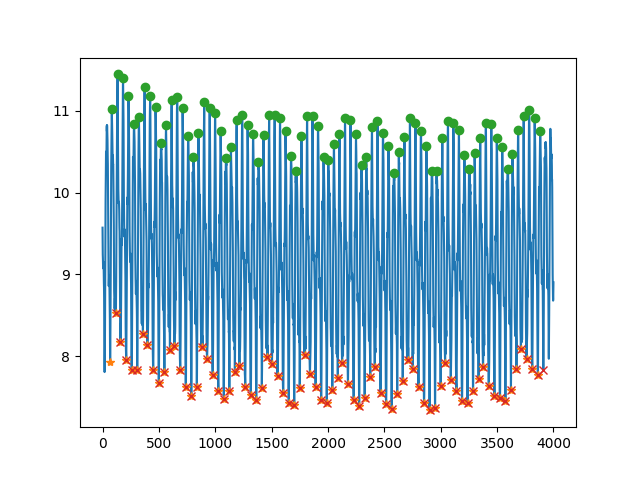

In [10]:
row = 8
col = 8
pixel_data = sequence.eit_data["raw"].pixel_impedance

start_indices = [
    np.argmax(sequence.eit_data["raw"].time == start_time)
    for pixel_inflation in pixel_inflations[:, row, col]
    if pixel_inflation is not None
    for start_time in [pixel_inflation.start_time]
]

middle_indices = [
    np.argmax(sequence.eit_data["raw"].time == middle_time)
    for pixel_inflation in pixel_inflations[:, row, col]
    if pixel_inflation is not None
    for middle_time in [pixel_inflation.middle_time]
]

end_indices = [
    np.argmax(sequence.eit_data["raw"].time == end_time)
    for pixel_inflation in pixel_inflations[:, row, col]
    if pixel_inflation is not None
    for end_time in [pixel_inflation.end_time]
]


plt.figure()
plt.plot(pixel_data[:, row, col])
plt.plot(start_indices, pixel_data[start_indices, row, col], "*")
plt.plot(middle_indices, pixel_data[middle_indices, row, col], "o")
plt.plot(end_indices, pixel_data[end_indices, row, col], "x")